<a href="https://colab.research.google.com/github/StanleyLiangYork/DeepLearningForMalaria/blob/master/implement_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import numpy as np
import os
from matplotlib import pyplot as plt

print(tensorflow.__version__)

2.2.0-rc2


Load the CIFAR10 dataset

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Plot a 10-by-10 image example

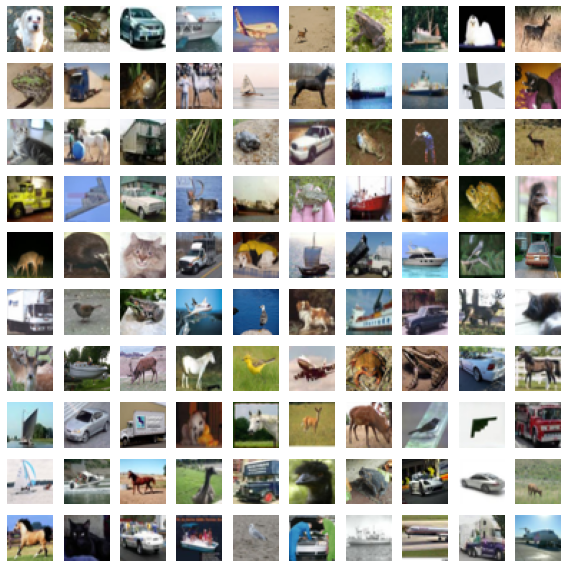

In [3]:
ROWS = 10
x = x_train.astype('uint8')
fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(8,8))

for i in range(ROWS):
  for j in range(ROWS):
    idx = np.random.choice(range(len(x)))
    axes1[i][j].axis('off')
    axes1[i][j].imshow(x[idx:idx+1][0])

plt.tight_layout()
plt.show()


In [0]:
def define_resnet():
  inputs = Input(shape=(32,32,3))
  x = Conv2D(64, (7,7), activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = AveragePooling2D(pool_size=2)(x)

  # start node of the first residual branch  
  x = Conv2D(64, (3,3), strides=2, activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # connect the top of the branch to the top of the main network
  branch_1 = Conv2D(64, (3,3), activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # merge the branch with the main path
  x = tensorflow.keras.layers.Add()([x,branch_1])
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)

  # start node of the second residual branch
  x = Conv2D(64, (3,3), activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # connect the top of the branch to the top of the main network
  branch_2 = Conv2D(64, (3,3), activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # merge the branch with the main path
  x = tensorflow.keras.layers.Add()([x, branch_2])
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)

  # start node of the third residual branch
  x = Conv2D(128, (3,3), strides=2, activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # connect the top of the branch to the top of the main network
  branch_3 = Conv2D(128, (3,3), activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # merge the branch with the main path
  x = tensorflow.keras.layers.Add()([x, branch_3])
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)

  # start node of the forth residual branch
  x = Conv2D(128, (3,3), activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # connect the top of the branch to the top of the main network
  branch_4 = Conv2D(128, (3,3), activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # merge the branch with the main path
  x = tensorflow.keras.layers.Add()([x, branch_4])
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)

  # start node of the fifth residual branch
  x = Conv2D(256, (3,3), strides=2, activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # connect the top of the branch to the top of the main network
  branch_5 = Conv2D(256, (3,3), activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # merge the branch with the main path
  x = tensorflow.keras.layers.Add()([x, branch_5])
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)

  # start node of the sixth residual branch
  x = Conv2D(256, (3,3), activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # connect the top of the branch to the top of the main network
  branch_6 = Conv2D(256, (3,3), activation=None, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
  # merge the branch with the main path
  x = tensorflow.keras.layers.Add()([x, branch_6])
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.3)(x)
  #x = AveragePooling2D(pool_size=2)(x)
  x = Flatten()(x)
  x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
  x = Dropout(0.4)(x)
  x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = Dropout(0.5)(x)
  y = Dense(10, activation='softmax')(x)
  model = Model(inputs=[inputs], outputs=y)
  # model = keras.models.Model(inputs=[input1, input2], outputs=out)
  return model

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
________________________________________________________________________

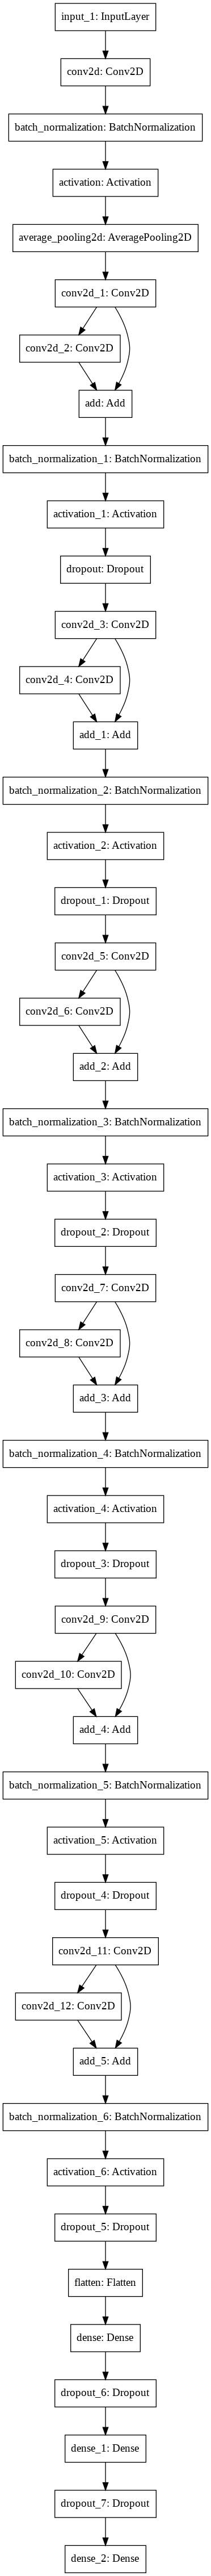

In [6]:
model = define_resnet()
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.summary()
plot_model(model)

In [7]:
# Normalize data.
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# subtract pixel mean to zero-center
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

NUM_CLASSES = 10

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def summarize_diagnostics(history):
  plt.figure(figsize=(10, 10))
  # plot loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], color='blue', label='Training')
  plt.plot(history.history['val_loss'], color='orange', label='Test')
  plt.legend(loc='lower right')
  plt.title('Cross Entropy Loss')
  # plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], color='blue', label='Training')
  plt.plot(history.history['val_accuracy'], color='orange', label='Test')
  plt.legend(loc='lower right')
  plt.title('Classification Accuracy')
  plt.show()

Learning rate:  0.001
Epoch 1/200
98/98 [==============================] - 5s 54ms/step - loss: 2.4741 - accuracy: 0.2001 - val_loss: 2.1904 - val_accuracy: 0.2950 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
98/98 [==============================] - 5s 46ms/step - loss: 2.0451 - accuracy: 0.3519 - val_loss: 2.1386 - val_accuracy: 0.3347 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
98/98 [==============================] - 5s 46ms/step - loss: 1.8057 - accuracy: 0.4559 - val_loss: 2.3493 - val_accuracy: 0.3297 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
98/98 [==============================] - 5s 46ms/step - loss: 1.6276 - accuracy: 0.5227 - val_loss: 1.6937 - val_accuracy: 0.5139 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
98/98 [==============================] - 5s 46ms/step - loss: 1.4935 - accuracy: 0.5774 - val_loss: 1.4804 - val_accuracy: 0.5701 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
98/98 [==============================] - 4s 46ms/step - loss: 1.3792 - accuracy: 

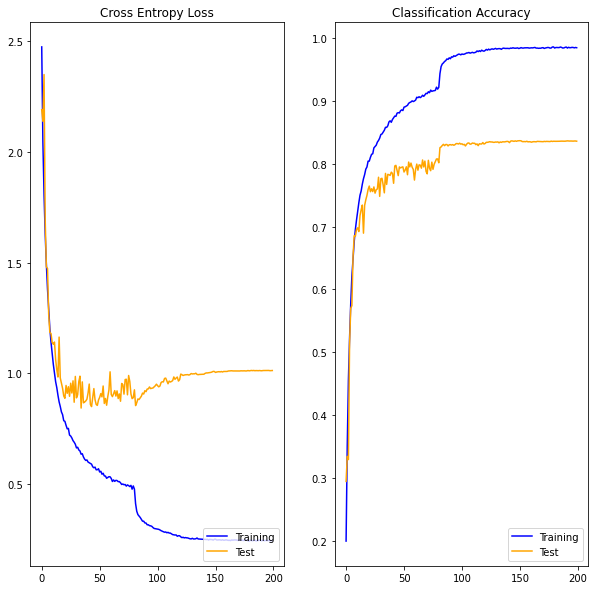

In [9]:
# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

history = model.fit(x_train, y_train,batch_size=512,epochs=200,validation_data=(x_test, y_test),shuffle=True,callbacks=callbacks)
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("loss: {:6.3f}, accuracy: {:6.3f}%".format(loss, acc*100))
summarize_diagnostics(history)

Set training parameters

Set a learning rate decay schedule

In [3]:
import time

start_time = time.time()

elapsed_time = time.time() - start_time
print('elapsed time: {:6.3f}'.format(elapsed_time))

elapsed time:  0.000
